In [1]:
# Import all necessary libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

## TASK 1: Data Preprocessing

### 1. Load the Dataset

In [2]:
# Load the Dataset

sampled_df = pd.read_csv(r"/Users/payalchavan/Documents/Data Mining_Assignments/Assignment 3/Seattle_Real_Time_Fire_911_Calls_20240318.csv")
seattle911_df = sampled_df.sample(n=10000)
seattle911_df.head()

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number
1233898,5915 Delridge Way Sw,Aid Response,01/23/2018 05:48:20 PM,47.549955,-122.363012,POINT (-122.363012 47.549955),F180008234
87228,N 46th St / Green Lake Way N,Aid Response,12/08/2004 09:34:46 AM,47.662127,-122.346089,POINT (-122.346089 47.662127),F040120538
1458341,131 10th Ave E,Rescue Elevator,10/23/2020 07:36:00 AM,47.619107,-122.319527,POINT (-122.319527 47.619107),F200105217
1421082,5427 Beach Dr Sw,Medic Response,09/03/2020 01:40:00 AM,47.553979,-122.399267,POINT (-122.399267 47.553979),F200087570
949847,810 Virginia St,Aid Response,04/12/2015 05:16:57 PM,47.615789,-122.336507,POINT (-122.336507 47.615789),F150039110


### 2. Data Cleaning and Exploration

In [3]:
# Take a look at the data structure
seattle911_df.shape

(10000, 7)

In [4]:
seattle911_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1233898 to 141048
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Address          10000 non-null  object 
 1   Type             10000 non-null  object 
 2   Datetime         10000 non-null  object 
 3   Latitude         9994 non-null   float64
 4   Longitude        9994 non-null   float64
 5   Report Location  9994 non-null   object 
 6   Incident Number  10000 non-null  object 
dtypes: float64(2), object(5)
memory usage: 625.0+ KB


In [5]:
# Summary Statistics
seattle911_df.describe()

,Latitude,Longitude
count,9994.000000,9994.000000
mean,47.620382,-122.330902
std,0.055305,0.030732
min,47.482515,-122.419022
25%,47.588437,-122.348010
50%,47.613506,-122.330233
75%,47.662127,-122.312631
max,47.748424,-122.242551


In [6]:
# Checking for missing values in the dataset
seattle911_df.isnull().sum()

Address            0
Type               0
Datetime           0
Latitude           6
Longitude          6
Report Location    6
Incident Number    0
dtype: int64

In [7]:
# Checking for duplicate records in the dataset
seattle911_df.duplicated().any()

False

In [8]:
# Handling missing values
# For Latitude and Longitude, we'll drop rows with missing values as they are crucial for geographical analysis
# For Report Location, we'll fill missing values with 'Unknown'
seattle911_df["Report Location"] = seattle911_df["Report Location"].fillna("Unknown")
seattle911_df.dropna(subset=["Latitude", "Longitude"], inplace=True)

# Check for missing values again to ensure they've been handled
missing_values_after = seattle911_df.isnull().sum()
print(missing_values_after)

Address            0
Type               0
Datetime           0
Latitude           0
Longitude          0
Report Location    0
Incident Number    0
dtype: int64


In [9]:
# Checking for outliers using the Z-score method
from scipy import stats
z_scores = stats.zscore(seattle911_df.select_dtypes(include=[np.number]))

In [10]:
# The threshold for an outlier is usually a Z-score of 3 or -3, i.e., data points that are 3 standard deviations away from the mean
seattle911_df = seattle911_df[(z_scores < 3).all(axis=1)]
seattle911_df.shape

(9994, 7)

### 3. Feature Engineering

In [11]:
from tqdm import tqdm
tqdm.pandas()

# Convert 'Datetime' to datetime type
seattle911_df['Datetime'] = pd.to_datetime(seattle911_df['Datetime'])
seattle911_df['Year'] = seattle911_df['Datetime'].dt.year
seattle911_df['Month'] = seattle911_df['Datetime'].dt.month
seattle911_df['Day'] = seattle911_df['Datetime'].dt.day
seattle911_df['Hour'] = seattle911_df['Datetime'].dt.hour

# Extract day of the week and time of day
# Day of the week
# Monday=0, Sunday=6
seattle911_df['DayOfWeek'] = seattle911_df['Datetime'].dt.dayofweek

# Time of day (Morning, Afternoon, Evening, Night)
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

seattle911_df['TimeOfDay'] = seattle911_df['Datetime'].dt.hour.progress_apply(get_time_of_day)

# Convert 'Type' to categorical type for modeling
seattle911_df['Type'] = seattle911_df['Type'].astype('category')

# Display the modified dataframe
seattle911_df.head()

100%|██████████████████████████████████| 9994/9994 [00:00<00:00, 2582422.02it/s]


,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number,Year,Month,Day,Hour,DayOfWeek,TimeOfDay
1233898,5915 Delridge Way Sw,Aid Response,2018-01-23 17:48:20,47.549955,-122.363012,POINT (-122.363012 47.549955),F180008234,2018,1,23,17,1,Evening
87228,N 46th St / Green Lake Way N,Aid Response,2004-12-08 09:34:46,47.662127,-122.346089,POINT (-122.346089 47.662127),F040120538,2004,12,8,9,2,Morning
1458341,131 10th Ave E,Rescue Elevator,2020-10-23 07:36:00,47.619107,-122.319527,POINT (-122.319527 47.619107),F200105217,2020,10,23,7,4,Morning
1421082,5427 Beach Dr Sw,Medic Response,2020-09-03 01:40:00,47.553979,-122.399267,POINT (-122.399267 47.553979),F200087570,2020,9,3,1,3,Night
949847,810 Virginia St,Aid Response,2015-04-12 17:16:57,47.615789,-122.336507,POINT (-122.336507 47.615789),F150039110,2015,4,12,17,6,Evening


Insights: Feature engineering has been successfully performed on the dataset. The following modifications were made:

1. In order to enable the extraction of additional characteristics, the 'Datetime' column was changed to a datetime datatype.
2. The 'DayOfWeek' feature was introduced to symbolize the day of the week that is taken from the Datetime column. Sunday is represented as 6, and Monday as 0.
3. Another new feature, 'TimeOfDay', was introduced to categorize the time of the incident into Morning (5 AM to 11:59 AM), Afternoon (12 PM to 4:59 PM), Evening (5 PM to 8:59 PM), and Night (9 PM to 4:59 AM) based on the hour of the incident.
4. The 'Type' column and 'TimeOfDay', which represents the type of incident and time of day, was later label encoded to facilitate modeling.

### Exploratory Data Anallysis:

In [12]:
# Displaying the top 10 incident types
top_9_incidents = seattle911_df['Type'].value_counts().head(9)
top_9_incidents

Type
Aid Response                    4869
Medic Response                  1706
Auto Fire Alarm                  540
Trans to AMR                     445
Aid Response Yellow              178
Motor Vehicle Accident           150
Automatic Fire Alarm Resd        145
MVI - Motor Vehicle Incident     122
Triaged Incident                 112
Name: count, dtype: int64

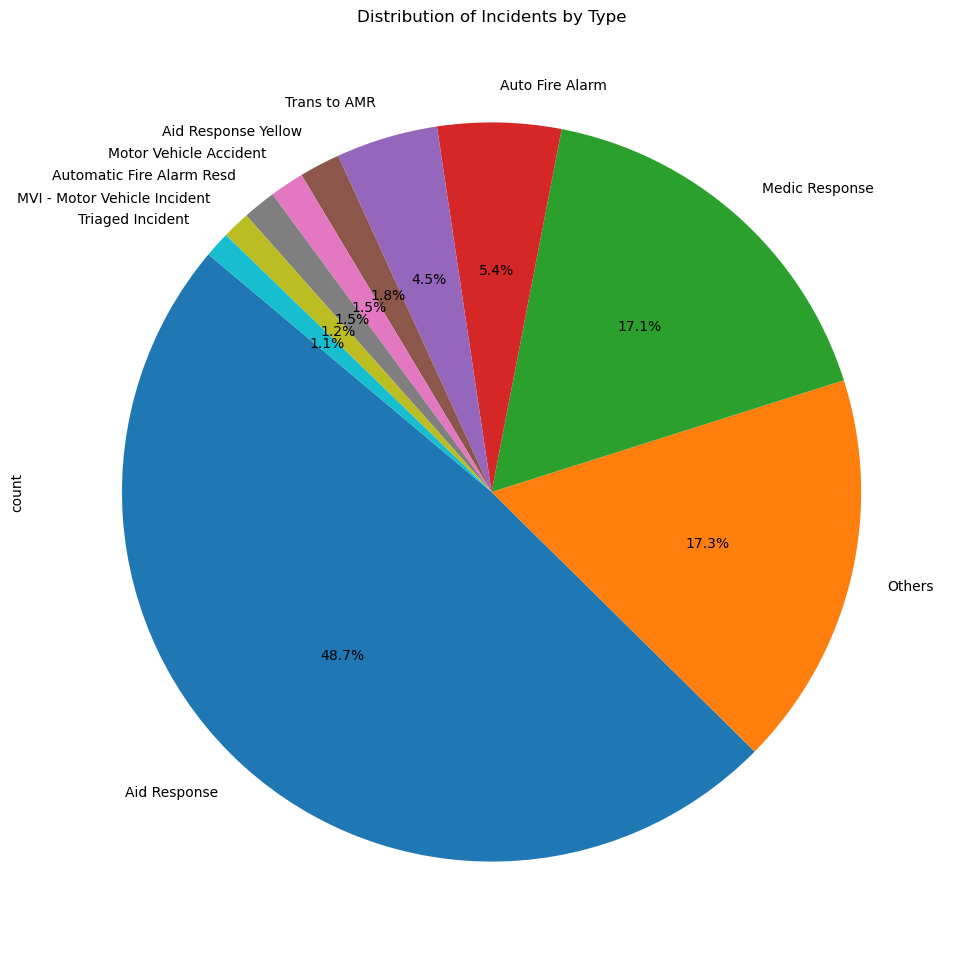

In [13]:
top_9_incidents = seattle911_df['Type'].value_counts().head(9).index
seattle911_df['Type'] = seattle911_df['Type'].apply(lambda x: x if x in top_9_incidents else 'Others')


# Plot a pie chart to check the distribution of 'Top 10 Types'.
plt.figure(figsize=(24, 12))
seattle911_df['Type'].value_counts().plot.pie(autopct="%1.1f%%", startangle=140, shadow=False)
plt.title("Distribution of Incidents by Type")
plt.show()

Insights: The number of different kinds of responses or incidences is shown in a pie chart. With 49.0% of the total events, Aid Response makes up the largest segment. With 16.8%, Medic Response comes next. 16.8% of the categories are labelled as Others. Smaller portions, such Auto Fire Alarm, Motor Vehicle Accident, Trans to AMR, Mutual Aid, Medic, and Aid Response Yellow, reflect particular occurrence categories. We must make sure that there are enough resources and training available to handle situations involving aid, given the significant percentage of aid response. Additionally, more research is needed to determine the causes of the high frequency of Medic Responses. In a similar vein, in order to address any patterns or abnormalities, we must keep an eye on the particular incident types in the smaller segments.

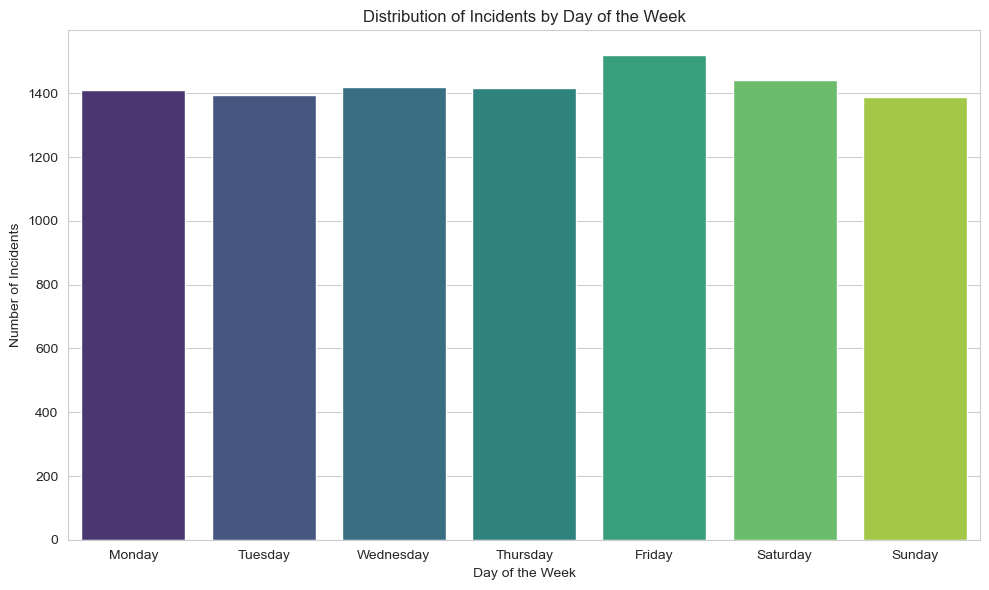

In [14]:
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Plotting the distribution of incidents by day of the week
plt.figure(figsize=(10, 6), facecolor='white')
ax = sns.countplot(x='DayOfWeek', data=seattle911_df, palette='viridis')
ax.set_title('Distribution of Incidents by Day of the Week')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Number of Incidents')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.tight_layout()
plt.show()

Insights: The number of occurrences reported for each day of the week is plotted. The most instances occur on Friday with approximately 1500 incidents. Monday, Tuesday, Wednesday have similar number of incidents, i.e., 1400. The lowest occurrence rate, which falls between 1200 and 1400 on Sunday. Information from this distribution can be very helpful for staffing, planning, and resource allocation. Because the incident count is typically high on Fridays, and Thursdays, we may want to consider dedicating additional staff or resources on these days. Investigating the reasons behind the increased incidents on the following 2 days is required.

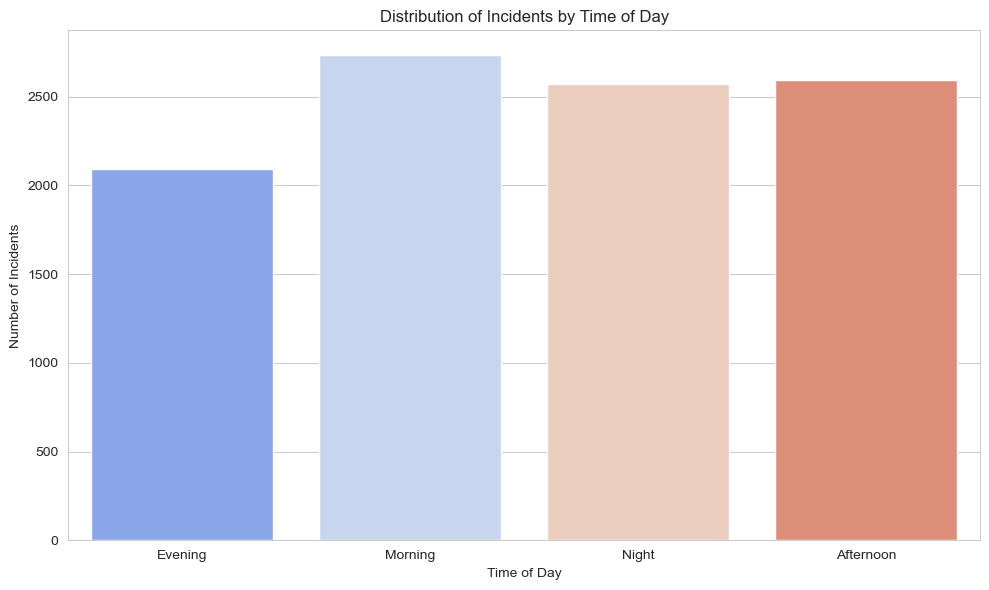

In [15]:
# Plotting the distribution of incidents by time of day
plt.figure(figsize=(10, 6), facecolor='white')
ax = sns.countplot(x='TimeOfDay', data=seattle911_df, palette='coolwarm')
ax.set_title('Distribution of Incidents by Time of Day')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Number of Incidents')
plt.tight_layout()
plt.show()

Insights: The number of occurrences reported for each time of day is plotted. Both the Morning and Afternoon had more than 2500 incidents. At Night, there are fewer incidents—about 2500 are reported. With approx 2000 events, Evenings have the fewest occurrences. Information from this distribution can be very helpful for staffing, planning, and resource allocation. Further investigatation of the reasons behind the reduced incidents during Evening is necessary.

In [16]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Perform label encoding on the 'Type' and 'TimeOfDay' column
seattle911_df['Type'] = label_encoder.fit_transform(seattle911_df['Type'])
seattle911_df['TimeOfDay'] = label_encoder.fit_transform(seattle911_df['TimeOfDay'])

seattle911_df.head()

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number,Year,Month,Day,Hour,DayOfWeek,TimeOfDay
1233898,5915 Delridge Way Sw,0,2018-01-23 17:48:20,47.549955,-122.363012,POINT (-122.363012 47.549955),F180008234,2018,1,23,17,1,1
87228,N 46th St / Green Lake Way N,0,2004-12-08 09:34:46,47.662127,-122.346089,POINT (-122.346089 47.662127),F040120538,2004,12,8,9,2,2
1458341,131 10th Ave E,7,2020-10-23 07:36:00,47.619107,-122.319527,POINT (-122.319527 47.619107),F200105217,2020,10,23,7,4,2
1421082,5427 Beach Dr Sw,5,2020-09-03 01:40:00,47.553979,-122.399267,POINT (-122.399267 47.553979),F200087570,2020,9,3,1,3,3
949847,810 Virginia St,0,2015-04-12 17:16:57,47.615789,-122.336507,POINT (-122.336507 47.615789),F150039110,2015,4,12,17,6,1


In [17]:
seattle911_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9994 entries, 1233898 to 141048
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Address          9994 non-null   object        
 1   Type             9994 non-null   int64         
 2   Datetime         9994 non-null   datetime64[ns]
 3   Latitude         9994 non-null   float64       
 4   Longitude        9994 non-null   float64       
 5   Report Location  9994 non-null   object        
 6   Incident Number  9994 non-null   object        
 7   Year             9994 non-null   int32         
 8   Month            9994 non-null   int32         
 9   Day              9994 non-null   int32         
 10  Hour             9994 non-null   int32         
 11  DayOfWeek        9994 non-null   int32         
 12  TimeOfDay        9994 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(5), int64(2), object(3)
memory usage: 897.9+ KB


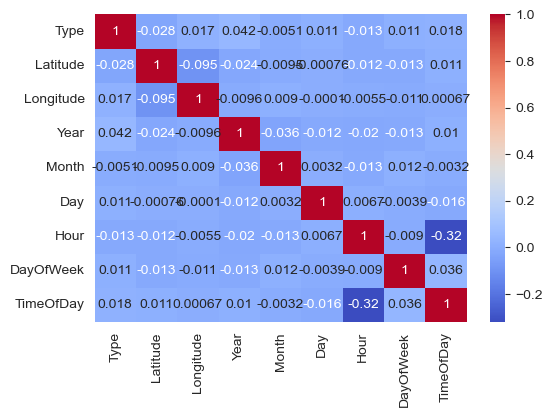

In [18]:
#Correlation matrix
#Exclude non-numerical columns from the correlation matrix calculation
numeric_columns = seattle911_df.select_dtypes(include=[np.number]).columns
corr_matrix = seattle911_df[numeric_columns].corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Insights: The plot represents the correlation coefficients between different variables: Type, Latitude, Longitude, DayOfWeek, and TimeOfDay, Year, Month, Day, and Hour. Since their absolute values are substantially lower than 0.5, the majority of other off-diagonal cells have weak correlations. Since the diagonal cells are all dark red and represent self-correlations, they all show a perfect positive correlation of 1. Given the positive link between Type and Longitude, it is possible that some event types are more prevalent in particular regions of the world. The lack of a substantial association between the other variables is indicated by their weak correlations. To find any patterns, we need to look at the relationship between the different sorts of incidents and the latitude and longitude coordinates. We need to examine additional variables that may affect the occurrence of incidents.

### 4. Data Splitting

In [29]:
# Prepare X (features) and y (target)
X = seattle911_df[['Latitude', 'Longitude', 'DayOfWeek', 'TimeOfDay', 'Year', 'Month', 'Day', 'Hour']]
y = seattle911_df['Type']

## TASK 2: Model Building and Evaluation

### 1. K-Nearest Neighbors (KNN)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


X = seattle911_df[['Latitude', 'Longitude', 'DayOfWeek', 'TimeOfDay', 'Year', 'Month', 'Day', 'Hour']]
y = seattle911_df['Type']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize kNN classifier
knn = KNeighborsClassifier(n_neighbors=13)  # Adjust k as needed

# Train the model
knn.fit(X_train_scaled, y_train)

# Make predictions
y_pred = knn.predict(X_test_scaled)

# Evaluate the model's performance
knn_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {knn_accuracy:.2f}")

Accuracy: 0.46


<Axes: >

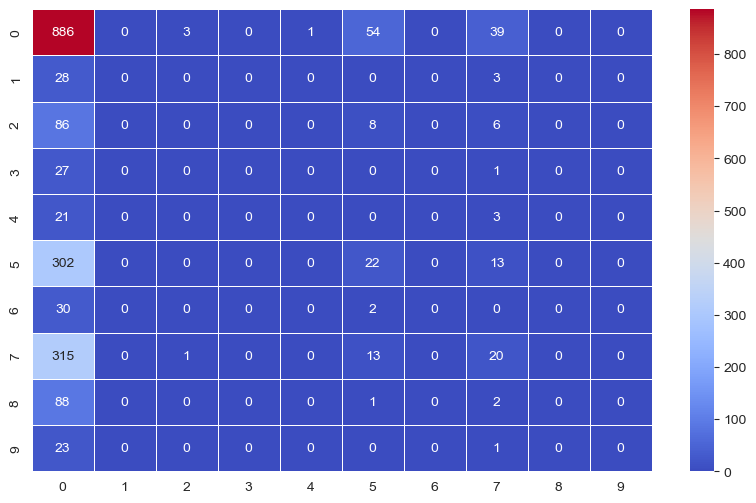

In [31]:
# Plot a confusion matrix using heatmap to visualize all the classes

from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 6))
confusion_matrix_knn = np.array(confusion_matrix(y_test, y_pred))
sns.heatmap(pd.DataFrame(confusion_matrix_knn), annot = True, cmap = 'coolwarm', fmt = 'g', linewidths=.5)

In [32]:
from sklearn.metrics import classification_report

# Compute the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.90      0.64       983
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        24
           5       0.22      0.07      0.10       337
           6       0.00      0.00      0.00        32
           7       0.23      0.06      0.09       349
           8       0.00      0.00      0.00        91
           9       0.00      0.00      0.00        24

    accuracy                           0.46      1999
   macro avg       0.09      0.10      0.08      1999
weighted avg       0.32      0.46      0.35      1999



### 2. Logistic Regression

In [33]:
# Using Feature Selection Method

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

rfe = RFE(estimator=LogisticRegression(), n_features_to_select=3, step=1)
rfe.fit(X, y)

for i in range(len(rfe.support_)):
    if rfe.support_[i]:
        print(f"feature {i+1} {X.columns[i]} is selected")

feature 3 DayOfWeek is selected
feature 4 TimeOfDay is selected
feature 6 Month is selected


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

# Select only numerical columns
#numeric_columns = seattle911_df.select_dtypes(include='number').columns

# Choose the selected features as predictors from the feature selection method
X = seattle911_df[['DayOfWeek', 'TimeOfDay',  'Month']]
y = seattle911_df['Type']  

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model
model = LogisticRegression(max_iter=3)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model's performance
logreg_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {logreg_accuracy:.2f}")

Accuracy: 0.49


<Axes: >

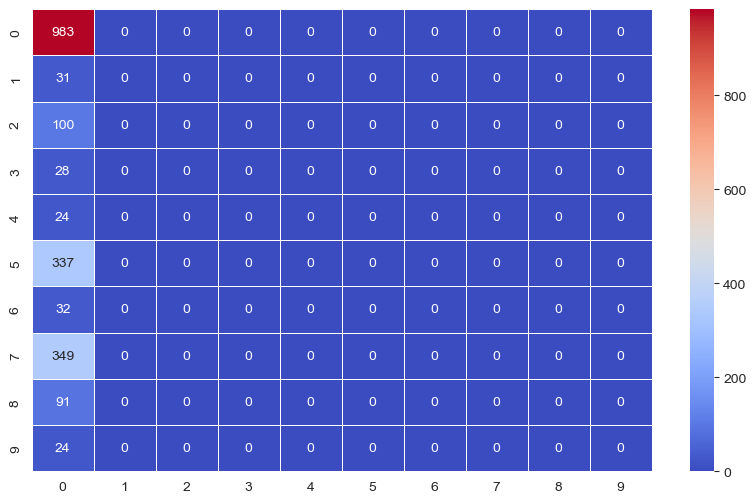

In [35]:
# Plot a confusion matrix using heatmap to visualize all the classes

from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 6))
confusion_matrix_logreg = np.array(confusion_matrix(y_test, y_pred))
sns.heatmap(pd.DataFrame(confusion_matrix_logreg), annot = True, cmap = 'coolwarm', fmt = 'g', linewidths=.5)

In [36]:
from sklearn.metrics import classification_report

# Compute the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       983
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00       337
           6       0.00      0.00      0.00        32
           7       0.00      0.00      0.00       349
           8       0.00      0.00      0.00        91
           9       0.00      0.00      0.00        24

    accuracy                           0.49      1999
   macro avg       0.05      0.10      0.07      1999
weighted avg       0.24      0.49      0.32      1999



## TASK 3: Comparative Analysis

### 1. Performance Comparison

1. KNN Classification Performance - The Knn claasification model has accuracy of 46%. This suggests that 46% of the time, the K-NN model accurately predicted the target variable's class. Even though accuracy is a valuable metric, it might not be enough on its own, particularly if there is an imbalance in the classes.

* Confusion Matrix Interpretation:

- Class 1 (True Positives): With 886 cases, this class has the greatest number of accurate predictions. These are accurate forecasts of success.

- Class 7 (False Positives): Regrettably, this class contains 315 incorrect categories. Although they belong to different classes, these cases were anticipated to be in Class 7.   

- Other Classes (Misclassifications): Misclassifications exist in certain other classes (Class 0 and Classes 2 through 9), but they are less common than in Class 2.


* Classification Report Interpretation:

- Class 1: This class has a respectable F1-score of 0.64, thanks to its comparatively high recall (0.90) and precision (0.49). It has 983 instances, which is strong support.

- Class 7: F1-score is 0.09, recall is 0.06, and precision is 0.23. There are 349 instances of this class supported.



* The overall model performance:
- Accuracy: The model correctly classified 46% of all instances.
- Macro Avg: Averages for precision (0.09), recall (0.10), and F1-score (0.08) across all classes.
- Weighted Avg: Averages considering class imbalance (precision: 0.32, recall: 0.46, F1-score: 0.35).

2. Logistic Regression Performance- 49% of the time, the Logistic Regression model is accurate. This indicates that the class of the target variable was predicted by the logistic regression model 50% of the time. While accuracy is a useful criterion, it may not be sufficient in and of itself, especially if there is a disparity in the classes.

* Confusion Matrix Interpretation:
- Class 0 (True Positives): There are a lot of true positives (983) in Class 0. Instances of class 0 can be accurately predicted by the model.

- Class 7 (True Positives): Additionally, Class 7 displays a sizable amount of true positives (349). When it comes to recognizing instances of class 7, the model does well.

- Misclassifications: There are several misclassifications; for example, class 2 is projected 41 times to be class 1 . In order to comprehend why some classes are incorrectly labeled, more research is required.While they are less frequent than in Class 6, they are still present in several other classes (Class 0 and Classes 2 through 9).


* Classification Report Interpretation:

- Precision: Shows the percentage of actual positive predictions for a class among all positive forecasts.
- Recall: Shows the percentage of real positive examples for a class that are true positive predictions.
- F1-Score: Provides a fair assessment of a model's accuracy by combining recall and precision.
- Support: Shows how many instances of each class there are in the dataset.

- Class 0 has precision of 0.49, recall of 1.00, and an F1-score of 0.66.
- Other classes (0 and 2-9) have precision, recall, and F1-score values of 0.00.

* The overall model performance:

- Accuracy: The model correctly classified 49% of all instances
- Macro Avg: Averages for precision (0.05), recall (0.10), and F1-score (0.07) across all classes.

- Weighted Avg: Averages considering class imbalance (precision: 0.24, recall: 0.49, F1-score: 0.32).
- The model does poorly for other classes, but it does well for class 0 (high recall and F1-score).
- It will need more investigation to determine the cause of some classes' poor performance.

### 2. Model Interpretation

1. K-Nearest Neighbors (KNN):

* KNN is a model that uses neighbor similarity to classify data.

* Because of the complexity of the dataset or the imbalance in classes, KNN may have trouble producing reliable predictions in the context of public safety.

* Because the model uses the complete training data set and doesn't offer a clear understanding of the underlying patterns, its interpretability is limited.

2. Logistic Regression:

* Using a logistic function, logistic regression models the likelihood of a binary outcome.

* As seen by the low precision, recall, and confusion matrix findings, Logistic Regression performs badly in this scenario even though its accuracy is higher.

* Compared to KNN which has accuracy of 46%, the interpretability and accuracy of Logistic Regression which is 49%, is higher since it yields interpretable coefficients that help determine how features affect the target variable.

## TASK 4: Conclusion

1. K-Nearest Neighbors (KNN):

 Pros- 
   * Simple and easy to understand.
   * Non-parametric: The distribution of the underlying data is not assumed.
   * Capable of managing multi class classifications.
   
 Cons-
   * Predictive computation is costly, particularly for huge datasets.
   * Sensitive to noisy data and unimportant features.
   * Must determine a suitable value for K, or the number of neighbors.
   
2. Logistic Regression:

 Pros-
   * Simple and comprehensible.
   * Quick and effective for both prediction and training.
   * Provides class membership probabilities.
   
  Cons-
   * Assumes that the relationship between log-odds and features is linear.
   * Unsuitable for intricate decision-making boundaries.
   * Prone to overfitting in the event of an excessive feature set.

Choosing the Best Fit:

KNN may be more appropriate if we suspect a nonlinear relationship between features and the target.
A excellent option if simplicity and interpretability are important is logistic regression.
To find out which model works better on your particular dataset, we need to evaluate both models using cross-validation and performance metrics (accuracy, precision, recall, and F1-score).

Potential Improvements include-
1. Feature Engineering: In order to enhance the performance of the model, investigate new features or modify current ones. Examine how different characteristics interact with one another or develop new composite features.

2. Hyperparameter Tuning: Make sure that the KNN and logistic regression hyperparameters are optimized. Employ methods such as random or grid search to determine the optimal set of hyperparameters.

3. Data Preprocessing: Address class imbalance (e.g., oversampling, undersampling, or using synthetic data).

4. Model Selection: Examine the performance of several classification techniques, such as SVM, random forests, and decision trees. Using ensemble techniques (such as boosting and bagging) may increase accuracy overall.

5. Feature Selection: Decide which aspects are relevant and retain them. Make use of strategies like feature significance ratings and recursive feature removal.

6. Cross-Validation: To more thoroughly evaluate model performance, use k-fold cross-validation. Test models using various subsets of the data to prevent overfitting.
